In [10]:
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 1
%aimport visualization.vis
%aimport utils.utils

In [11]:
import pytorch_lightning as pl
import cv2
import matplotlib.pyplot as plt
import io

from torch_geometric.loader import DataLoader
from argparse import ArgumentParser
from datasets import ArgoverseV2Dataset
from predictors import QCNet
from predictors.autoval import AntoQCNet
from predictors.environment import WorldModel
from transforms import TargetBuilder
from av2.datasets.motion_forecasting import scenario_serialization
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)
from av2.map.map_api import ArgoverseStaticMap
from pathlib import Path
from visualization.vis import plot_traj_with_data, plot_traj, vis_reward, generate_video
from utils.utils import get_transform_mat, get_auto_pred, add_new_agent, reward_function

pl.seed_everything(2023, workers=True)

parser = ArgumentParser()
parser.add_argument("--model", type=str, default="QCNet")
parser.add_argument("--root", type=str, default="/home/guanren/Multi-agent-competitive-environment/datasets")
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--num_workers", type=int, default=8)
parser.add_argument("--pin_memory", type=bool, default=True)
parser.add_argument("--persistent_workers", type=bool, default=True)
parser.add_argument("--accelerator", type=str, default="auto")
parser.add_argument("--devices", type=int, default=1)
parser.add_argument("--ckpt_path", default="checkpoints/epoch=10-step=274879.ckpt", type=str)
args = parser.parse_args("")

model = {
    "QCNet": AntoQCNet,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
environment = {
    "QCNet": WorldModel,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
val_dataset = {
    "argoverse_v2": ArgoverseV2Dataset,
}[model.dataset](
    root=args.root,
    split="val",
    transform=TargetBuilder(model.num_historical_steps, model.num_future_steps),
)


Global seed set to 2023
/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.1, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


In [12]:
dataloader = DataLoader(
    # val_dataset[[val_dataset.raw_file_names.index('0a8dd03b-02cf-4d7b-ae7f-c9e65ad3c900')]],
    # val_dataset[[val_dataset.raw_file_names.index('0a0ef009-9d44-4399-99e6-50004d345f34')]],
    val_dataset[[val_dataset.raw_file_names.index('0a09b183-3553-4c85-9a12-976409e4aeab')]],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory,
    persistent_workers=args.persistent_workers,
)

trainer = pl.Trainer(accelerator=args.accelerator, devices=args.devices)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
it = iter(dataloader)
data = next(it)

/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


In [14]:
scenario_id = data["scenario_id"][0]
argoverse_scenario_dir = Path("/home/guanren/Multi-agent-competitive-environment/datasets/val/raw")

all_scenario_files = sorted(argoverse_scenario_dir.rglob(f"*_{scenario_id}.parquet"))
scenario_file_list = list(all_scenario_files)
scenario_path = scenario_file_list[0]
print(scenario_path)

static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
scenario_static_map = ArgoverseStaticMap.from_json(static_map_path)

/home/guanren/Multi-agent-competitive-environment/datasets/val/raw/8ff85423-3f41-49c1-b81f-dfabd54a1a90/scenario_8ff85423-3f41-49c1-b81f-dfabd54a1a90.parquet


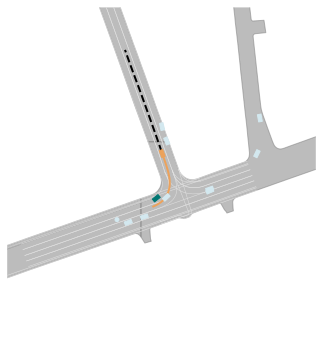

In [15]:
plot_traj(scenario_static_map,scenario)

In [16]:

for param in model.encoder.parameters():
        param.requires_grad = False
for param in model.decoder.parameters():
        param.requires_grad = False

from torch_geometric.data import Batch
from utils import wrap_angle
import torch, math
import copy
import numpy as np

if isinstance(data, Batch):
    data['agent']['av_index'] += data['agent']['ptr'][:-1]

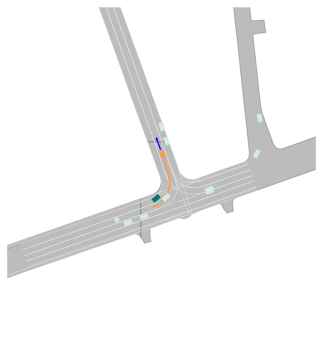

In [17]:
plot_traj_with_data(data,scenario_static_map,1,t=50)
agent_index = torch.nonzero(data['agent']['category']==3,as_tuple=False).item()
# print(data['agent']['position'][agent_index,50:,:2])
# print(data['agent']['heading'][agent_index,50:])

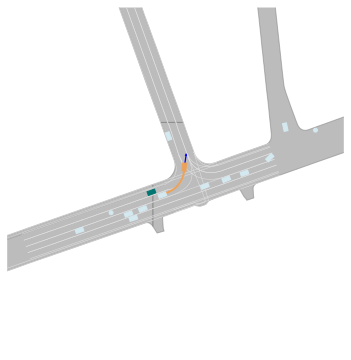

In [30]:

# v0_x = 1*math.cos(1.19)
# v0_y = math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(data,0.3, v0_x, v0_y, 1.19, 2665, -2410)
# v0_x = 1*math.cos(-1.95)
# v0_y = -math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, -1.95, 2693, -2340)
# v0_x = -1*math.cos(-0.33)
# v0_y = math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,-0.3, v0_x, v0_y, -0.33, 2725, -2386)

# v0_x = 1*math.cos(1.9338)
# v0_y = math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(data,0.5, v0_x, v0_y, 1.9338, 5259.7, 318)
# v0_x = 1*math.cos(5.07)
# v0_y = -math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.3, v0_x, v0_y, 5.07, 5229.7, 400)
# v0_x = 1*math.cos(5.07)
# v0_y = -math.sqrt(1**2-v0_x**2)
# new_input_data=add_new_agent(new_input_data,0.1, v0_x, v0_y, 5.07, 5235.7, 395)
# init_origin,init_theta,init_rot_mat=get_transform_mat(new_input_data,model)


v0_x = 1*math.cos(0.1)
v0_y = math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(data,0.5, v0_x, v0_y, 0.1, -8379.8809, -827)
v0_x = -1*math.cos(3.15)
v0_y = -math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(new_input_data,0.8, v0_x, v0_y, 3.15, -8299, -823)
v0_x = 1*math.cos(4.76)
v0_y = -math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(new_input_data,0.8, v0_x, v0_y, 4.76, -8341, -773)
v0_x = 1*math.cos(4.76)
v0_y = -math.sqrt(1**2-v0_x**2)
new_input_data=add_new_agent(new_input_data,0.8, v0_x, v0_y, 4.76, -8345, -773)

plot_traj_with_data(new_input_data,scenario_static_map,5, bounds=80,t=30)

In [31]:
vid_path = "test1.webm"
generate_video(new_input_data,scenario_static_map, model, vid_path)

tensor([[5.3742, 5.4306, 5.4161, 5.5072, 5.4662, 5.5785]], device='cuda:0')
tensor([[10.2834, 10.2374, 10.2221, 10.2998, 10.2668, 10.3506]],
       device='cuda:0')
tensor([[15.1425, 15.0831, 15.0814, 15.1366, 15.1045, 15.2078]],
       device='cuda:0')
tensor([[20.1623, 19.9806, 19.9656, 20.0113, 19.9868, 20.0539]],
       device='cuda:0')
tensor([[24.7144, 24.7017, 24.6682, 24.7444, 24.7281, 24.7599]],
       device='cuda:0')
tensor([[29.0791, 29.1444, 29.0981, 29.1746, 29.1718, 29.1667]],
       device='cuda:0')
tensor([[33.0181, 33.0806, 33.0273, 33.1113, 33.1080, 33.1440]],
       device='cuda:0')
tensor([[36.8485, 36.8955, 36.8479, 36.9682, 36.9558, 37.0082]],
       device='cuda:0')
tensor([[40.6996, 40.7678, 40.7530, 40.8197, 40.7957, 40.9183]],
       device='cuda:0')
tensor([[44.6708, 44.6385, 44.6550, 44.7614, 44.6702, 44.7593]],
       device='cuda:0')
tensor([[48.0575, 48.1872, 48.0751, 48.2767, 48.2346, 48.3660]],
       device='cuda:0')
tensor([[50.8255, 50.7820, 50.7833

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


/tmp/ipykernel_269589/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


IndexError: The shape of the mask [29] at index 0 does not match the shape of the indexed tensor [30, 6, 60, 4] at index 0

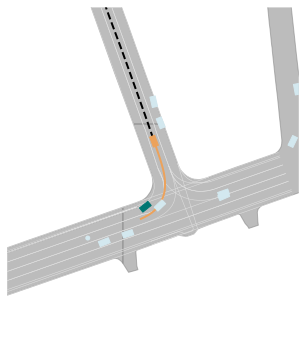

In [ ]:
plot_traj(50.0)
for i in range(6):
    xy = true_traj_refine[[data["agent"]["category"] == 2]][0].cpu().detach()
    plt.plot(xy[i, ..., 0], xy[i, ..., 1])
# for i in range(6):
#     xy = new_position[1][data["agent"]["category"] == 3][0].cpu().detach()
#     plt.plot(xy[i, ..., 0], xy[i, ..., 1])


In [ ]:
[x.value for x in _STATIC_OBJECT_TYPES]

In [15]:

import csv, random

data = []

for i in range(1, 501):
    # if 31 <= i <= 50:
    #     data.append(random.uniform(300, 500))
    # elif 51 <= i <= 100:
    #     data.append(random.uniform(500, 600))
    # else:
    #     data.append(random.uniform(600, 850))
    data.append(random.uniform(-16, -18))

data = [[num] for num in data]

with open('/home/guanren/Multi-agent-competitive-environment/figures/version_29/BC_seed1234_task2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)
print('done')

done


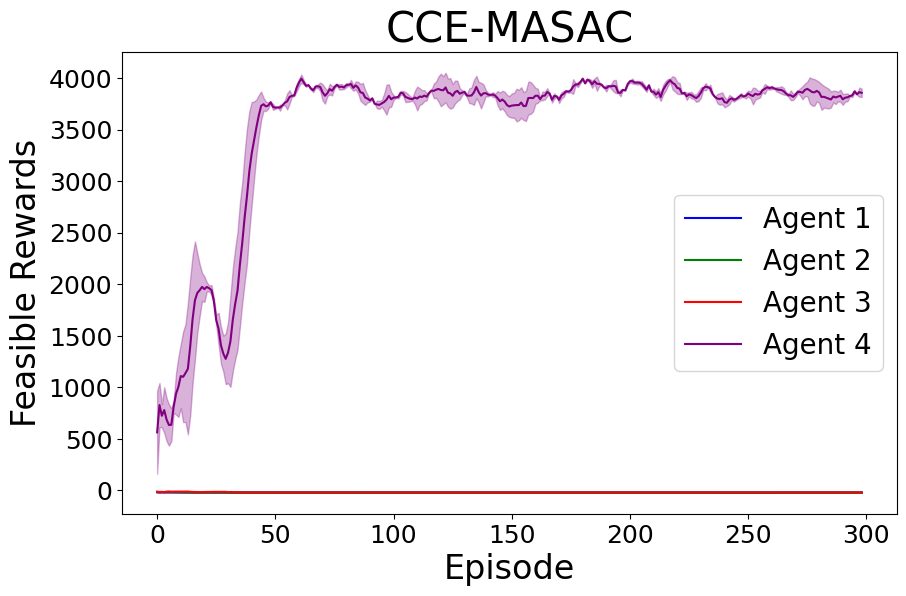

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#file_paths = ['/home/guanren/Multi-agent-competitive-environment/figures/version_30/MASAC_episode500_epoch10_beta1e-1_seed1000_task2_agent-number4.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_31/MASAC_episode500_epoch10_beta1e-1_seed1234_task2_agent-number4.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_32/MASAC_episode500_epoch10_beta1e-1_seed666_task2_agent-number4.csv']
# file_paths = ['/home/guanren/Multi-agent-competitive-environment/figures/version_33/MASAC_episode500_epoch10_beta1e-1_seed1000_task2_agent-number4.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_34/MASAC_episode500_epoch10_beta1e-1_seed1234_task2_agent-number4.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_35/MASAC_episode500_epoch10_beta1e-1_seed666_task2_agent-number4.csv']
file_paths= ['/home/guanren/Multi-agent-competitive-environment/figures/version_43/MASAC_episode500_epoch10_beta1e-1_seed1234_task2_agent-number4.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_41/MASAC_episode500_epoch10_beta1e-1_seed666_task2_agent-number4.csv']
colors = ['blue', 'green', 'red','purple']

agent_data = {}

for file_path in file_paths:
    data = pd.read_csv(file_path)
    for (i, column) in enumerate(data.columns):
        if i not in agent_data:
            agent_data[i] = data[column]
        else:
            agent_data[i] = pd.concat([agent_data[i], data[column]], axis=1)

window_size = 10
for agent_id in agent_data:
    agent_data[agent_id] = agent_data[agent_id].rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(10, 6))
for agent_id, data in agent_data.items():
    mean_values = data.mean(axis=1)
    max_values = data.max(axis=1)
    min_values = data.min(axis=1)

    plt.plot(mean_values, label=f'Agent {agent_id+1}', color=colors[agent_id])
    plt.fill_between(range(len(mean_values)), min_values, max_values, color=colors[agent_id], alpha=0.3)

plt.title('CCE-MASAC', fontsize=30)
plt.xlabel('Episode', fontsize=24)
plt.ylabel('Feasible Rewards', fontsize=24)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('MARL-4.png')
plt.show()


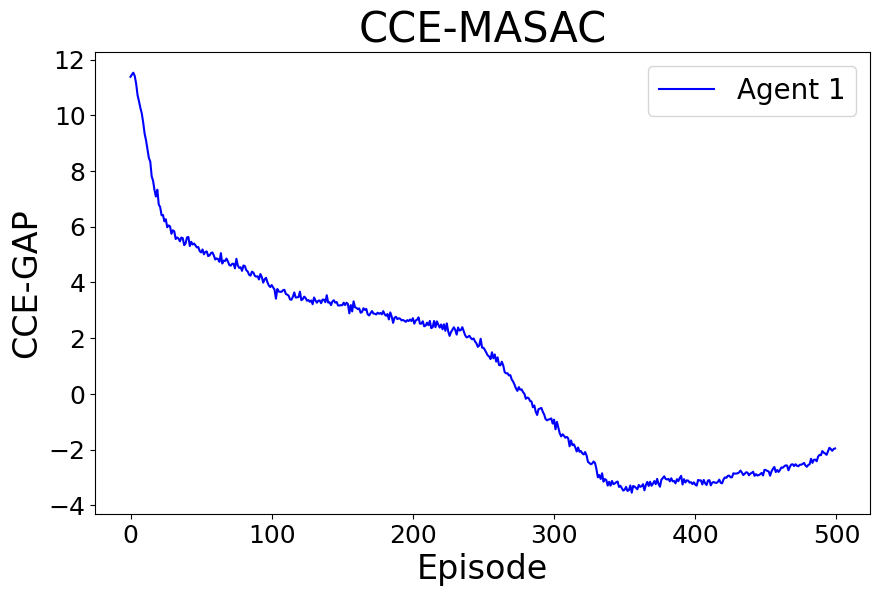

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#file_paths = ['/home/guanren/Multi-agent-competitive-environment/figures/version_30/MASAC_episode500_epoch10_beta1e-1_seed1000_task2_agent-number4.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_31/MASAC_episode500_epoch10_beta1e-1_seed1234_task2_agent-number4.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_32/MASAC_episode500_epoch10_beta1e-1_seed666_task2_agent-number4.csv']
file_paths = ['/home/guanren/Multi-agent-competitive-environment/figures/version_43/CCE-MASAC_episode500_epoch10_beta1e-2_seed1234_task2_CCE-GAP_agent1.csv']
expert_data = ['/home/guanren/Multi-agent-competitive-environment/figures/version_53/expert_CCE-MASAC_episode500_epoch10_beta1e-2_seed1234_task2_CCE-GAP_agent1.csv']
colors = ['blue', 'green', 'red','purple']

data1 = pd.read_csv(file_paths[0],header=None)
# data2 = pd.read_csv(file_paths[1],header=None)
# data3 = pd.read_csv(file_paths[2],header=None)

expert_data1 = pd.read_csv(expert_data[0],header=None)

data1 = expert_data1 - data1

# df_combined = pd.concat([data1, data2, data3], axis=0)
df_combined = data1

window_size = 10
df_combined.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(10, 6))

mean_values = df_combined.mean(axis=0)
std_values = df_combined.std(axis=0)

plt.plot(mean_values, label=f'Agent 1', color=colors[0])
plt.fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=colors[0], alpha=0.3)

plt.title('CCE-MASAC', fontsize=30)
plt.xlabel('Episode', fontsize=24)
plt.ylabel('CCE-GAP', fontsize=24)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.savefig('cce-gap-4.png')
plt.show()

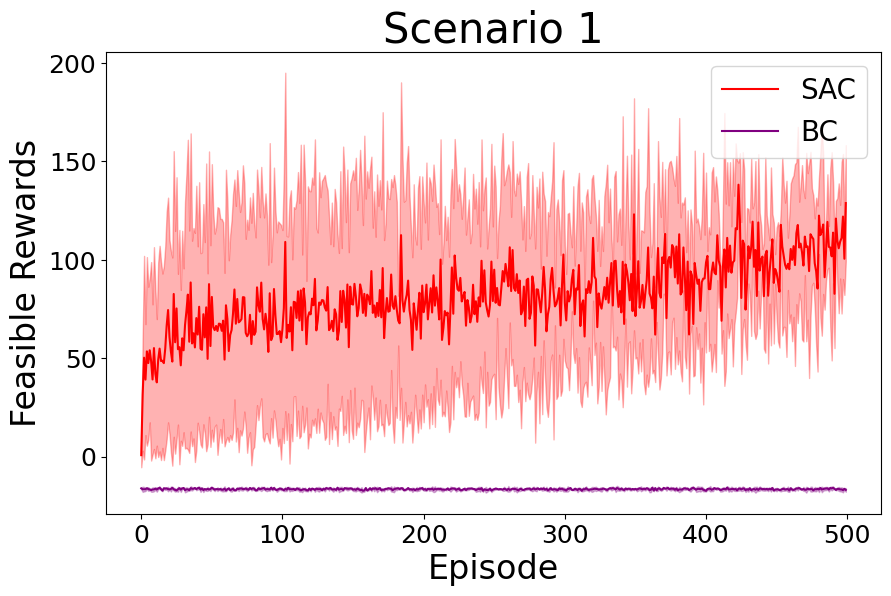

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

datas = []
labels = ['SAC', 'BC']
#file_paths = ['/home/guanren/Multi-agent-competitive-environment/figures/version_30/MASAC_episode500_epoch10_beta1e-1_seed1000_task2_agent-number4.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_31/MASAC_episode500_epoch10_beta1e-1_seed1234_task2_agent-number4.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_32/MASAC_episode500_epoch10_beta1e-1_seed666_task2_agent-number4.csv']
file_paths1 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_24/CCE-MASAC_episode500_epoch20_beta1e-2_seed1000_task2.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_23/CCE-MASAC_episode500_epoch20_beta1e-2_seed1234_task2.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_25/CCE-MASAC_episode500_epoch20_beta1e-2_seed666_task2.csv']
colors = ['red','purple']

file_paths2 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_1/MAPPO_episode500_epoch20_beta1e-1_seed666_task2.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_3/MAPPO_episode500_epoch20_beta1e-1_seed1000_task2.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_9/MAPPO_episode500_epoch20_beta1e-1_seed1234_task2.csv']

# data1 = pd.read_csv(file_paths2[0], header=None, usecols=[0]).transpose()
# data2 = pd.read_csv(file_paths2[1], header=None, usecols=[0]).transpose()
# data3 = pd.read_csv(file_paths2[2], header=None, usecols=[0]).transpose()
# df_combined2 = pd.concat([data1, data2, data3], axis=0)
# datas.append(df_combined2)

file_paths3 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_33/MASAC_episode500_epoch10_seed1234_task2_agent-number1.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_34/MASAC_episode500_epoch10_seed1000_task2_agent-number1.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_35/CCE-MASAC_episode500_epoch10_beta1e-2_seed666_task2_agent-number1.csv']

data1 = pd.read_csv(file_paths3[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths3[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths3[2], header=None, usecols=[0]).transpose()
df_combined3 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined3)

file_paths4 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_29/BC_seed666_task2.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_29/BC_seed1000_task2.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_29/BC_seed1234_task2.csv']

data1 = pd.read_csv(file_paths4[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths4[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths4[2], header=None, usecols=[0]).transpose()
df_combined4 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined4)

plt.figure(figsize=(10, 6))
for i in range(2):
    window_size = 10
    datas[i].rolling(window=window_size, min_periods=1).mean()

    mean_values = datas[i].mean(axis=0)
    std_values = datas[i].std(axis=0)

    plt.plot(mean_values, label=labels[i], color=colors[i])
    plt.fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=colors[i], alpha=0.3)

plt.title('Scenario 1', fontsize=30)
plt.xlabel('Episode', fontsize=24)
plt.ylabel('Feasible Rewards', fontsize=24)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.savefig('cce-gap-4.png')
plt.show()


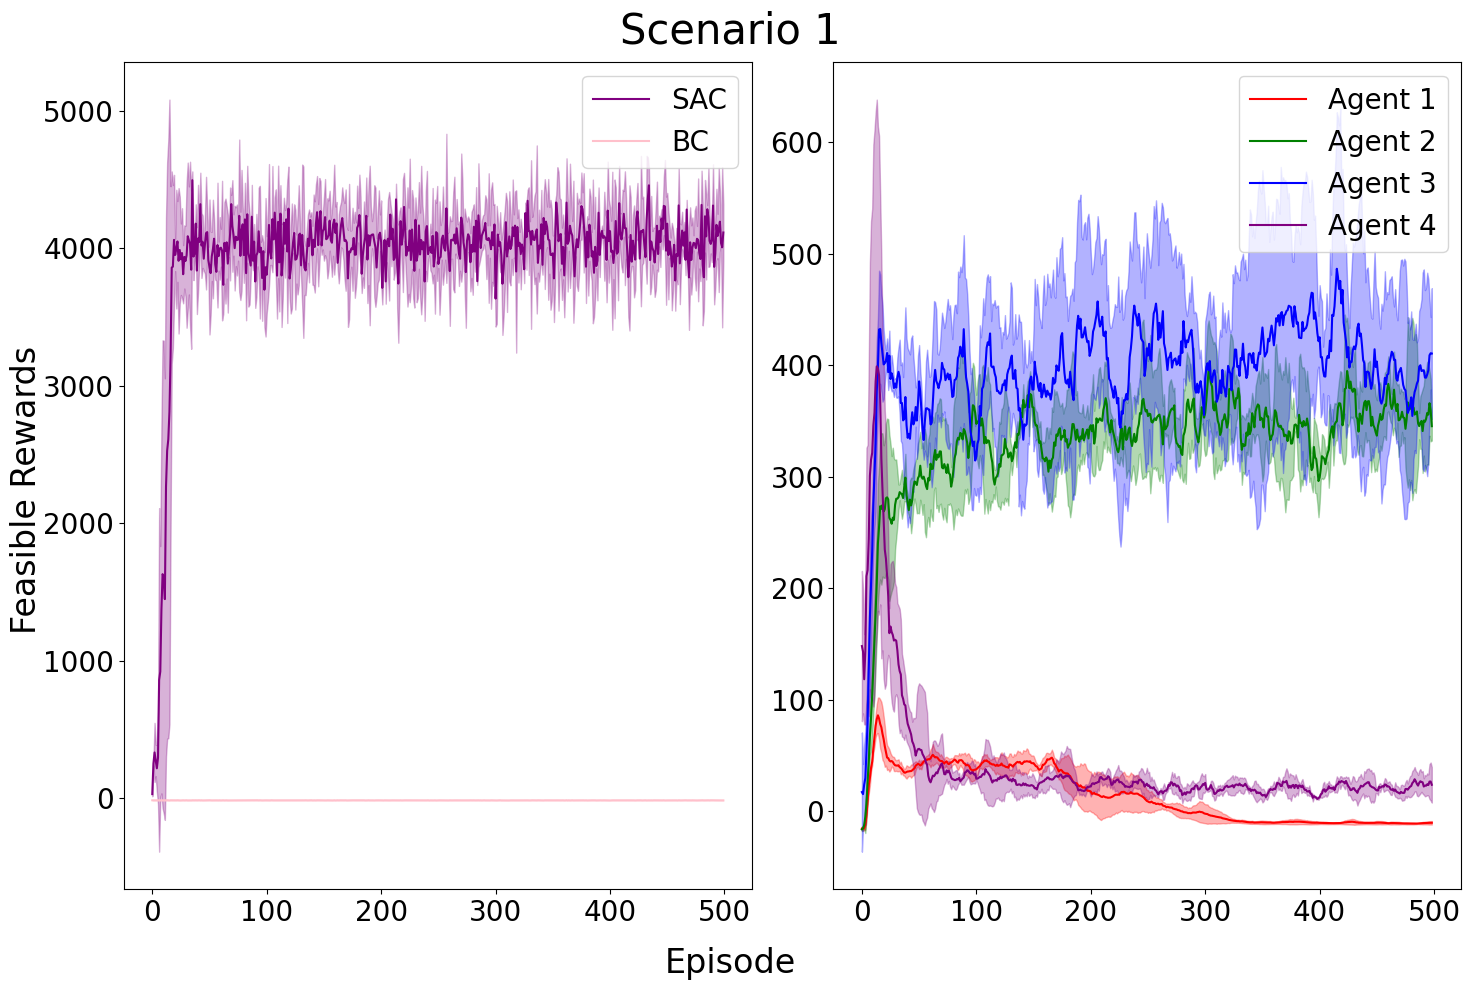

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=False)

datas = []
labels = ['SAC', 'BC']
colors = ['purple','pink']

# file_paths3 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_33/MASAC_episode500_epoch10_seed1234_task2_agent-number1.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_34/MASAC_episode500_epoch10_seed1000_task2_agent-number1.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_11/MASAC_episode500_epoch10_seed666_task2.csv']
# file_paths3 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_44/SAC_episode500_epoch10_seed1234_task2_agent-3_agent-number1.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_45/SAC_episode500_epoch10_seed666_task2_agent-3_agent-number1.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_46/SAC_episode500_epoch10_seed1000_task2_agent-3_agent-number1.csv']
# file_paths3 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_47/SAC_episode500_epoch10_seed1234_task2_agent-2_agent-number1.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_49/SAC_episode500_epoch10_seed666_task2_agent-2_agent-number1.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_50/SAC_episode500_epoch10_seed1000_task2_agent-2_agent-number1.csv']
file_paths3 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_48/SAC_episode500_epoch10_seed1234_task2_agent-1_agent-number1.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_51/SAC_episode500_epoch10_seed1000_task2_agent-1_agent-number1.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_52/SAC_episode500_epoch10_seed666_task2_agent-1_agent-number1.csv']
data1 = pd.read_csv(file_paths3[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths3[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths3[2], header=None, usecols=[0]).transpose()
df_combined3 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined3)

file_paths4 = ['/home/guanren/Multi-agent-competitive-environment/figures/version_29/BC_seed666_task2.csv', '/home/guanren/Multi-agent-competitive-environment/figures/version_29/BC_seed1000_task2.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_29/BC_seed1234_task2.csv']

data1 = pd.read_csv(file_paths4[0], header=None, usecols=[0]).transpose()
data2 = pd.read_csv(file_paths4[1], header=None, usecols=[0]).transpose()
data3 = pd.read_csv(file_paths4[2], header=None, usecols=[0]).transpose()
df_combined4 = pd.concat([data1, data2, data3], axis=0)
datas.append(df_combined4)

for i in range(2):
    window_size = 10
    datas[i].rolling(window=window_size, min_periods=1).mean()

    mean_values = datas[i].mean(axis=0)
    std_values = datas[i].std(axis=0)

    axs[0].plot(mean_values, label=labels[i], color=colors[i])
    axs[0].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=colors[i], alpha=0.3)

file_paths= ['/home/guanren/Multi-agent-competitive-environment/figures/version_43/CCE-MASAC_episode500_epoch10_beta1e-2_seed1234_task2_agent-number4.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_42/CCE-MASAC_episode500_epoch10_beta1e-2_seed1000_task2_agent-number4.csv','/home/guanren/Multi-agent-competitive-environment/figures/version_41/CCE-MASAC_episode500_epoch10_beta1e-2_seed666_task2_agent-number4.csv']
colors = ['red', 'green', 'blue','purple']

agent_data = {}

for file_path in file_paths:
    data = pd.read_csv(file_path)
    for (i, column) in enumerate(data.columns):
        if i not in agent_data:
            agent_data[i] = data[column]
        else:
            agent_data[i] = pd.concat([agent_data[i], data[column]], axis=1)

window_size = 10
for agent_id in agent_data:
    agent_data[agent_id] = agent_data[agent_id].rolling(window=window_size, min_periods=1).mean()

for agent_id, data in agent_data.items():
    mean_values = data.mean(axis=1)
    std_values = data.std(axis=1)

    axs[1].plot(mean_values, label=f'Agent {agent_id+1}', color=colors[agent_id])
    axs[1].fill_between(range(len(mean_values)), mean_values+std_values, mean_values-std_values, color=colors[agent_id], alpha=0.3)

for ax in axs:
    ax.legend(fontsize=20)

for ax in axs:
    ax.tick_params(axis='both', labelsize=20)

fig.suptitle('Scenario 1', fontsize=30)
fig.supxlabel('Episode', fontsize=24)
fig.supylabel('Feasible Rewards', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()